The AdjointSecondOrderODEModel seeks to infer the forcing functon of a linear second order differential equation of the form:

\begin{equation}
-K_0\frac{d^2x}{dt^2}+u\frac{dx}{dt}+\eta_0 x(t)=f(t)
\end{equation}
with initial conditions:

\begin{equation}
x(0)=0
\end{equation}
and
\begin{equation}
\frac{dx(0)}{dt}=0
\end{equation}

The forcing function, $f$ is approximated using Random Fourier Features so that

\begin{equation}
f(t)\sim \sum_{i=1}^{M}\phi_i(t)z_i
\end{equation}

$f$ is then inferred using the adjoint method as in Gahungu et al. (2022).

# Import Modules

In [2]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which consists of the start and end times of the observation period. 

In [3]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,100) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

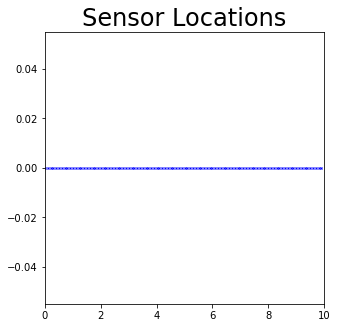

In [4]:
plt.rcParams["figure.figsize"] = (5,5)

plt.xlim(0,10)
plt.title("Sensor Locations",fontsize=24)
plt.plot((X[:,1]-avg/2),np.zeros(len(X)),'xk',markersize=2,color='b');

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [5]:
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a Nt=100 grid in time.

### Establish forward model parameters

In [6]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

### Initialise model and calculate ground truth source, concentration and observations

Here we use a constant source at a fixed location, but include code (commented out) for a source term calculated by approximating a gaussian process with an EQ kernel. Any source of the right dimensions can be used to simulate the forward problem.

In [7]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

# Inverse Problem Example

In [8]:
#%%timeit
N_feat =500 #Number of features used to infer the source
kInverse = EQ(0.6, 4) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source


Calculating Adjoints...
99/100 
Calculating Phis...
499/500 


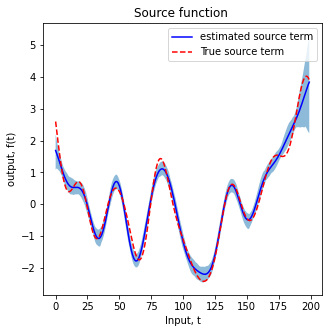

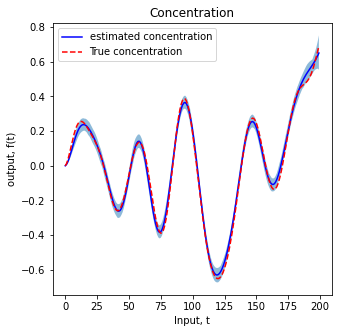

In [9]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

In [12]:
m.getGridCoord(tlocL)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198])

In [ ]:
def cost(conc,obs,tloc)
    cost = np.zeros(res)
    cost[m.getGridCoord(tlocL)]=2*(conc[m.getGridCoord(tlocL)]-obs)

In [ ]:
def computeGradientAdjoint(cost):
    """
    Runs the backward second order ODE (adjoint problem)
    Gets called for an observation instance (H).
    (v is the result of the adjoint operation)
    """
    dt,dt2,Nt = self.getGridStepSize()
    k_0=self.k_0
    u=self.u
    eta=self.eta
    v=np.zeros(((self.resolution)))
    v[Nt-1] = 0
    #v[Nt-2]=0
    #v[Nt-2] = (1.0/(-k_0+u*dt/2))*( H[Nt-1]*(dt**2)+ k_0*v[Nt-1]+u*dt*v[Nt-1]/2.0- 2*k_0*v[Nt-1]-eta*(dt**2)*v[Nt-1]     )

    for i in reversed(range(1,Nt-1)):
        #i=Nt-j-2
        v[i-1]=(1.0/(1+(u/-k_0)*dt/2))*( cost[i]*(dt2)+ v[i+1]+(u/-k_0)*dt*v[i+1]/2.0- 2*v[i]-(eta/-k_0)*(dt2)*v[i]     )

    return v